Epoch [1/300] - Combined Loss: 52214.4795, MSE: 52154.1000, SR: -603.7949
Epoch [2/300] - Combined Loss: 48672.3272, MSE: 48667.7583, SR: -45.6883
Epoch [3/300] - Combined Loss: 46269.0121, MSE: 46266.3373, SR: -26.7472
Epoch [4/300] - Combined Loss: 44111.4958, MSE: 44109.5814, SR: -19.1442
Epoch [5/300] - Combined Loss: 42189.6055, MSE: 42188.0989, SR: -15.0661
Epoch [6/300] - Combined Loss: 40254.0972, MSE: 40252.8826, SR: -12.1458
Epoch [7/300] - Combined Loss: 38514.3685, MSE: 38513.3522, SR: -10.1625
Epoch [8/300] - Combined Loss: 36721.6551, MSE: 36720.7868, SR: -8.6834
Epoch [9/300] - Combined Loss: 35029.3897, MSE: 35028.6382, SR: -7.5143
Epoch [10/300] - Combined Loss: 33459.1969, MSE: 33458.5415, SR: -6.5525
Epoch [11/300] - Combined Loss: 32071.2743, MSE: 32070.6956, SR: -5.7856
Epoch [12/300] - Combined Loss: 30604.7276, MSE: 30604.2124, SR: -5.1527
Epoch [13/300] - Combined Loss: 29190.9104, MSE: 29190.4471, SR: -4.6329
Epoch [14/300] - Combined Loss: 27903.9806, MSE: 279

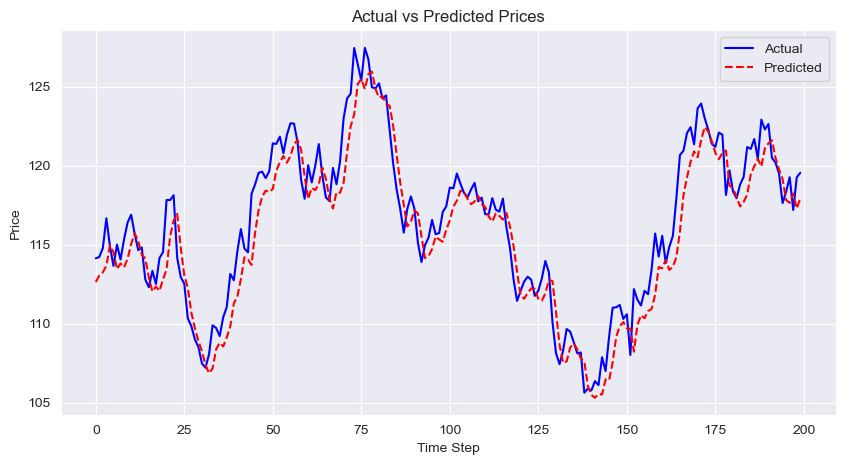

Epoch [101/300] - Combined Loss: 133.7102, MSE: 133.6939, SR: -0.1633
Epoch [102/300] - Combined Loss: 124.1480, MSE: 124.1355, SR: -0.1257
Epoch [103/300] - Combined Loss: 114.6871, MSE: 114.6754, SR: -0.1169
Epoch [104/300] - Combined Loss: 109.0443, MSE: 109.0318, SR: -0.1249
Epoch [105/300] - Combined Loss: 99.4189, MSE: 99.4057, SR: -0.1318
Epoch [106/300] - Combined Loss: 95.5544, MSE: 95.5411, SR: -0.1325
Epoch [107/300] - Combined Loss: 87.5438, MSE: 87.5282, SR: -0.1560
Epoch [108/300] - Combined Loss: 81.0004, MSE: 80.9883, SR: -0.1213
Epoch [109/300] - Combined Loss: 76.0253, MSE: 76.0143, SR: -0.1105
Epoch [110/300] - Combined Loss: 70.7482, MSE: 70.7401, SR: -0.0811
Epoch [111/300] - Combined Loss: 65.8271, MSE: 65.8146, SR: -0.1247
Epoch [112/300] - Combined Loss: 62.2671, MSE: 62.2585, SR: -0.0855
Epoch [113/300] - Combined Loss: 62.5619, MSE: 62.5493, SR: -0.1259
Epoch [114/300] - Combined Loss: 55.4436, MSE: 55.4343, SR: -0.0930
Epoch [115/300] - Combined Loss: 55.9787

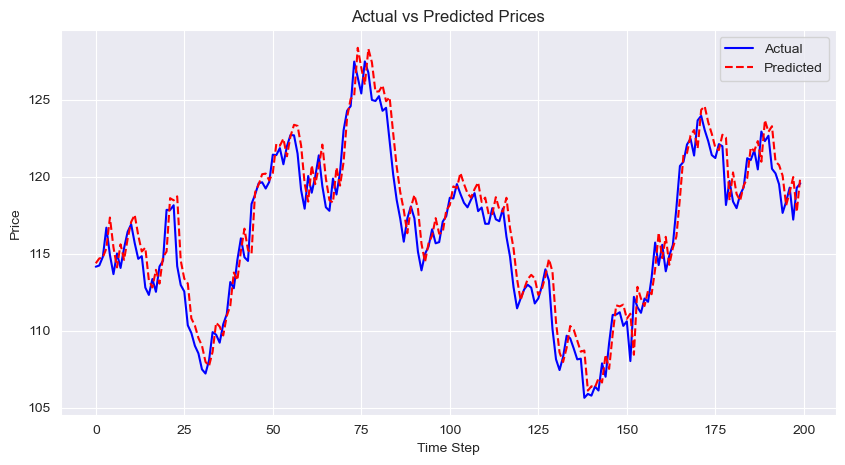

Epoch [201/300] - Combined Loss: 13.0212, MSE: 13.0432, SR: 0.2196
Epoch [202/300] - Combined Loss: 11.3131, MSE: 11.3253, SR: 0.1222
Epoch [203/300] - Combined Loss: 12.1187, MSE: 12.1356, SR: 0.1687
Epoch [204/300] - Combined Loss: 12.2764, MSE: 12.2966, SR: 0.2027
Epoch [205/300] - Combined Loss: 12.4400, MSE: 12.4532, SR: 0.1328
Epoch [206/300] - Combined Loss: 12.2622, MSE: 12.2712, SR: 0.0898
Epoch [207/300] - Combined Loss: 12.0684, MSE: 12.0916, SR: 0.2320
Epoch [208/300] - Combined Loss: 13.3648, MSE: 13.3825, SR: 0.1764
Epoch [209/300] - Combined Loss: 14.2361, MSE: 14.2568, SR: 0.2076
Epoch [210/300] - Combined Loss: 11.8532, MSE: 11.8633, SR: 0.1006
Epoch [211/300] - Combined Loss: 12.0724, MSE: 12.0870, SR: 0.1462
Epoch [212/300] - Combined Loss: 14.1376, MSE: 14.1518, SR: 0.1413
Epoch [213/300] - Combined Loss: 12.2240, MSE: 12.2321, SR: 0.0811
Epoch [214/300] - Combined Loss: 12.3437, MSE: 12.3663, SR: 0.2262
Epoch [215/300] - Combined Loss: 12.6694, MSE: 12.6735, SR: 0.

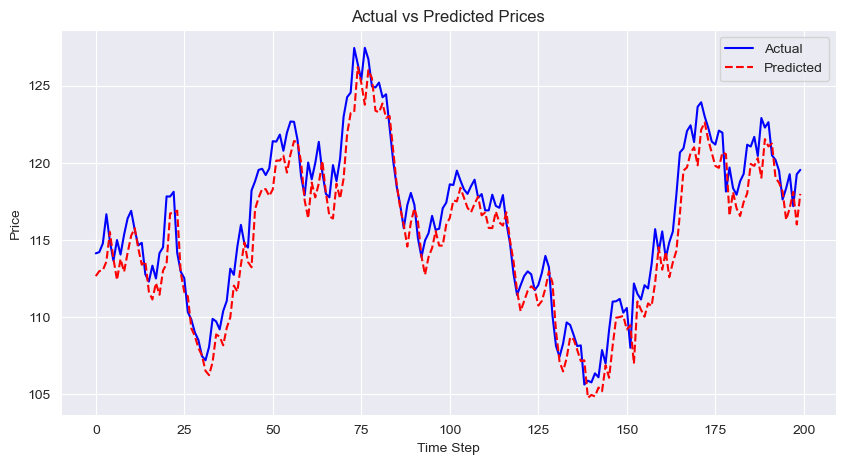

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import matplotlib.pyplot as plt

#####################################
# GBM-Based Synthetic Dataset
#####################################
class GBMDataset(Dataset):
    def __init__(self, length=5000, seq_len=50, S0=100, mu=0.05, sigma=0.2, dt=1/252):
        self.seq_len = seq_len
        total_length = length + seq_len
        # Generate GBM prices
        prices = torch.zeros(total_length)
        prices[0] = S0
        for t in range(1, total_length):
            Z = torch.randn(1)
            prices[t] = prices[t-1] * torch.exp((mu - 0.5 * sigma**2)*dt + sigma*math.sqrt(dt)*Z)
        self.data = prices
        
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        # x: (seq_len,), y: scalar
        return x.unsqueeze(-1), y.unsqueeze(-1)  # (seq_len,1), (1,)

#####################################
# LSTM Model
#####################################
class TwoLayerLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(TwoLayerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        preds = self.fc(last_out)
        return preds

#####################################
# Sharpe Ratio Function
#####################################
def sharpe_ratio(returns):
    mean_ret = torch.mean(returns)
    std_ret = torch.std(returns)
    if std_ret == 0:
        return torch.tensor(0.0, device=returns.device)
    return mean_ret / std_ret

#####################################
# Training Parameters
#####################################
seq_len = 50
batch_size = 32
epochs = 300   # example number of epochs
learning_rate = 0.001
lambda_sr = 0.1

#####################################
# Prepare Data
#####################################
train_dataset = GBMDataset(length=5000, seq_len=seq_len, S0=100, mu=0.05, sigma=0.2, dt=1/252)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = GBMDataset(length=1000, seq_len=seq_len, S0=110, mu=0.05, sigma=0.2, dt=1/252)

#####################################
# Model, Loss, Optimizer
#####################################
model = TwoLayerLSTM(input_size=1, hidden_size=32, num_layers=2, output_size=1)
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#####################################
# Predict and Plot Function
#####################################
def predict_and_plot(model, test_dataset, N=200):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for i in range(min(len(test_dataset), N)):
            features, target = test_dataset[i]
            features = features.unsqueeze(0)  # (1, seq_len, 1)
            pred = model(features)
            predictions.append(pred.item())
            actuals.append(target.item())
    
    plt.figure(figsize=(10,5))
    plt.plot(range(len(actuals)), actuals, label='Actual', color='blue')
    plt.plot(range(len(predictions)), predictions, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    model.train()

#####################################
# Training Loop (Sharpe Ratio on Returns)
#####################################
model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_sr = 0.0
    count = 0

    for features, targets in train_loader:
        optimizer.zero_grad()
        
        # Predict next-day price
        preds = model(features)
        
        # MSE Loss on prices
        mse_loss = criterion_mse(preds, targets)
        
        # Compute returns from predictions
        # last_price in the input sequence:
        last_price = features[:, -1, 0]
        # predicted return and actual return
        predicted_returns = (preds.squeeze() - last_price) / last_price
        
        # Compute Sharpe ratio on predicted returns
        sr = sharpe_ratio(predicted_returns)
        
        # Combined loss
        loss = mse_loss - lambda_sr * sr
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_mse += mse_loss.item()
        epoch_sr += sr.item()
        count += 1

    avg_loss = epoch_loss / count
    avg_mse = epoch_mse / count
    avg_sr = epoch_sr / count
    print(f"Epoch [{epoch}/{epochs}] - Combined Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f}, SR: {avg_sr:.4f}")

    # Every 100 epochs, do a prediction and plot
    if epoch % 100 == 0:
        predict_and_plot(model, test_dataset, N=200)


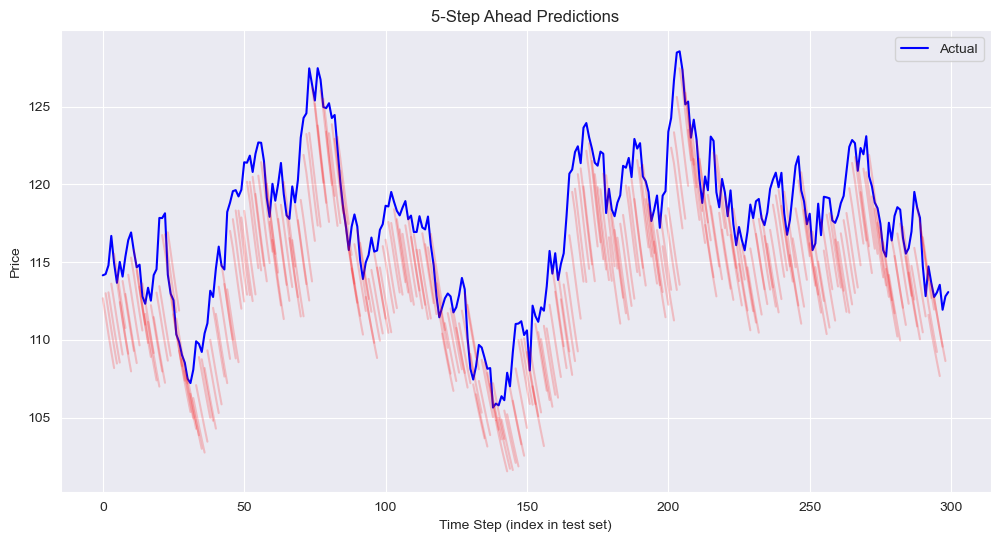

In [27]:
model.eval()

# Parameters for prediction
forecast_horizon = 5  # how many steps ahead to predict
num_samples_to_plot = 20  # how many different sequences to plot

# We'll plot the actual prices for a range of the test dataset
# Let's say we plot the first 300 points of the test dataset's actual prices
N_actual_plot = 300

# Extract actual values from the test dataset for plotting
actual_values = []
for i in range(len(test_dataset)):
    # test_dataset[i] = (features, target)
    # features: (seq_len, 1), target: (1,)
    # The "actual values" here will be the target values aligned after seq_len steps.
    # If we want the full series, we can reconstruct it from the dataset.
    _, y = test_dataset[i]
    actual_values.append(y.item())

# The actual_values are the next-step prices. They start after seq_len from the original data.
# For plotting actual values from index 0 in test_dataset terms, 
# these represent prices at indices [seq_len ... seq_len+(len(test_dataset)-1)] in original scale.
# Just keep it simple and plot them as is. They represent the actual "future" points.

plt.figure(figsize=(12,6))
plt.plot(range(N_actual_plot), actual_values[:N_actual_plot], label='Actual', color='blue')

# Generate multiple forecasts
# We'll pick sequences from different starting points in the test data
# For each starting index, we take the 50-step historical window and predict next 5 steps.
for start_idx in range((N_actual_plot - forecast_horizon)):
    if start_idx >= len(test_dataset):
        break

    # Get the initial features (the last 50 points of a sequence)
    features, _ = test_dataset[start_idx]
    # features: (seq_len, 1)
    current_sequence = features.clone().detach().unsqueeze(0) # (1, seq_len, 1)

    predicted_points = []
    # We have one-step-ahead predictions, so we loop 5 times
    for step in range(forecast_horizon):
        with torch.no_grad():
            pred = model(current_sequence)  # pred: (1,1)
        
        predicted_price = pred.item()
        predicted_points.append(predicted_price)

        # Append this predicted price to the sequence, remove the oldest price
        # Shift the window forward by one step
        new_price_tensor = torch.tensor([[predicted_price]], dtype=torch.float32)
        # current_sequence shape: (1, seq_len, 1)
        current_sequence = torch.cat([current_sequence[:,1:,:], new_price_tensor.unsqueeze(0)], dim=1)

    # Now we have predicted_points: a list of 5 future prices after start_idx
    # The first predicted point corresponds to test_dataset[start_idx] target,
    # which itself is positioned at start_idx in `actual_values`.
    # So predicted_points[0] aligns with actual_values[start_idx],
    # predicted_points[1] aligns with actual_values[start_idx+1], and so forth.
    #
    # We'll plot these predicted points starting at 'start_idx' on the x-axis.
    # The x-axis for predicted points:
    x_range = range(start_idx, start_idx + forecast_horizon)
    plt.plot(x_range, predicted_points, color='red', alpha=0.2)  # low alpha to see multiple paths

plt.title('5-Step Ahead Predictions')
plt.xlabel('Time Step (index in test set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()